## Data 620 - Final Project


**Contributor:**  Valerie Briot

**Date:**         12/20/2017

### Project Overview
As a final project I am planning to perform an analysis of the book; “Le comte de Monte-Cristo” (“The count of Monte Cristo”) by Alexandre Dumas (père).  This story of vengeance, justice, and redemption happens to be my favorite book.  The analysis would be to compare the original French version and the English translation, not for translation accuracy but to explore potential words association between the two versions.  I am curious to explore whether the same story told in two different language would lead to different results.

In [696]:
# import required packages and libraries
import nltk 

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from nltk.collocations import *

import collections

import string

import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import bipartite

# inline matplotlib
%matplotlib inline

#import sys
#reload(sys)
#sys.setdefaultencoding('utf8')

#print(sys.getdefaultencoding())

### Approach  

For the chosen text
* we will compile the list of most occurring words, we will exclude stopwords and proper name (including character names and places)
* Compile the bigrams that include these names

* Build the graph of words that comprised these bigrams, linked if words are in the same bigrams.

### Data Source

The “Project Gutenberg” offers both the French version and an English version in plain text UTF-8  

| Book                                                                  | Text Number |  
|-----------------------------------------------------------------------|:-----------:|  
| "The Count of Monte Cristo, Illustrated by Alexandre Dumas", English  | 1184        |  
| "Le comte de Monte-Cristo, Tome I by Alexandre Dumas", French         | 17989       |  
| "Le comte de Monte-Cristo, Tome II by Alexandre Dumas", French        | 17990       |  
| "Le comte de Monte-Cristo, Tome III by Alexandre Dumas", French       | 17991       | 
| "Le comte de Monte-Cristo, Tome IV by Alexandre Dumas", French        | 17992       |   

#### 1. Downloading of Text

In [697]:
# import the full English version
#from urllib import urlopen
import urllib2

url_e = "http://www.gutenberg.org/files/1184/1184-0.txt"
response = urllib2.urlopen(url_e)

raw_e = response.read().decode('utf8')

# Confirm that we have unicode for text
type(raw_e)

unicode

In [698]:
# Lenght of English Text
len(raw_e)

2705011

In [699]:
# import the French version (Volume I)

url_f = "http://www.gutenberg.org/cache/epub/17989/pg17989.txt"

response = urllib2.urlopen(url_f)

raw_f = response.read().decode('utf8')

# Confirm that we have unicode for text
type(raw_f)

unicode

In [700]:
# Length of French Text
len(raw_f)

764056

#### 2. Organization of the raw text and extraction

** English Text **

Each text downloaded from Project Gutenberg contains a header with the name of the text, the author, the names of people who scanned and corrected the text, a license, and so on. Sometimes this information appears in a footer at the end of the file. We cannot reliably detect where the content begins and ends, and so have to resort to manual inspection of the file, to discover unique strings that mark the beginning and the end,

Upon examining the text, we realized that there is a small introduction at the begining and a large section at the end of the text.  In addition, there is a cover page and a table of content that list all the chapter in each volumes.  

The end of the full book ends with the very famous quote: "Wait and hope (Fac et spera)!" just before the FOOTNOTES section which is part of the book.  For this analysis, we will ignore the footnote section. Hence "FOOTNOTES:" will be our end tag.

We want to tag the first chapter of the first volume as the begining of the test: "Chapter 1. Marseilles—The Arrival", since the chapter is also listed in the table of content, we need to find the 2nd occurence of this string.

In [701]:
# Identify, the 2nd occurence of the first chapter (1st occurrence is in Table of Content)
# Need to make sure that all strings are converted to unicode as not to confuse methods used by python,
# otherwise we get codec error
i_0_e = raw_e.find("Chapter 1. Marseilles—The Arrival".decode("utf8"))

i_1_e = raw_e.find("Chapter 1. Marseilles—The Arrival".decode("utf8"), i_0_e +1)

# Identify, the end of the text
i_f_e = raw_e.rfind("FOOTNOTES:".decode("utf8"))

raw_e_edited = raw_e[i_1_e: i_f_e]

** French Text ** 

Upon examining the text similarly to the English version, we will use the same tag for the begining of the book, mainly the title of the first chapter "Marseille.--L'arrivée.". Again, we will need to identified the 2nd occurence of this tag.  

For the end tag, we will use "FIN DU TOME PREMIER" as our end tag which signify; "End of Volume I".  

In [702]:
# Identify, the 2nd occurence of the first chapter for volume 1
# Need to make sure that all strings are converted to unicode as not to confuse methods used by python,
# otherwise we get codec error
i_0_f = raw_f.find("Marseille.--L'arrivée.".decode("utf8"))

i_1_f = raw_f.find("Marseille.--L'arrivée.".decode("utf8"), i_0_f +1)

# Identify, the end of the text
i_f_f = raw_f.rfind("FIN DU TOME PREMIER".decode("utf8"))

raw_f_edited = raw_f[i_1_f: i_f_f]

For the time being we will consider the first 5 chapter of the Volume 1, these chapters introduced the main characters and their relationships to each other. Describes as well, the act of betrayal which the vengeance is the basis of the story. Chapter 5 culuminates with the arrest of the protagonist, Edmond Dantes.  

In [703]:
# For English and French Text, end tag is the begining of Chapter VI
i_6 = raw_e_edited.find("Chapter 6. The Deputy Procureur du Roi".decode("utf8"))

i_6_f = raw_f_edited.find("Le substitut du procureur du roi.".decode("utf8"))

In [704]:
# Extract first 5 chapters of English Text
raw_e_edited_5 = raw_e_edited[: i_6] 

In [705]:
# Extract first 5 chapters of French Text
raw_f_edited_5 = raw_f_edited[: i_6_f]

### Text Analysis

#### 1. Word Tokenization

We will start by "tokenize" the text into words and then remove stand-alone punctuation. 

Some of the main characters in the book are introduced in these 5 first chapters; 

Edmond Dantes, Danglars, Ferdinand, Caderousse, Mercedes, Morrel  

Some other words of note in the list of 50 most frequent words are; 
man, young, father, old, captain, Pharaon (which is the name of a ship the main character serves on), dear, love, owner, friend

These words (including the characters) capture quite accurately the first 5 chapter of the book; 

Edmond Dantes, although a young man is second in command of the ship Pharaon. He is named captain of the ship by the owner (Morrel) at a return from a successful trip although the captain of the ship (Leclere) died during the trip.  Edmond love and is loved by his fiancee, Mercedes, and they are to marry. Danglars and Ferdinand are jealous of him, for his success, Danglars covet the captaincy and Ferdinand covet the love of Mercedes.

Both Danglars and Ferdinand are responsible for having Dantes imprisoned.  

In [706]:
# Tokenize into sentences and words and filter punctuation
translate_table = dict((ord(char), None) for char in string.punctuation)   

words_e = word_tokenize (raw_e_edited_5.translate(translate_table))
words_f = word_tokenize (raw_f_edited_5.translate(translate_table))

In [707]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

We will remove Unicode double, single quote, and quotation marks.  

In [708]:
# Remove Unicode double and single quotes
words_e_nopunct = [w for w in words_e if not w in [u'\u201c', u'\u201d', u'\u2019', u'\xab', u'\xbb', u'\u2018']]
words_f_nopunct = [w for w in words_f if not w in [u'\u201c', u'\u201d', u'\u2019', u'\xab', u'\xbb', u'\u2018']]

In [709]:
# Build stop-words for English language
stopwords_e = set(stopwords.words("english"))
stopwords_f = set(stopwords.words("french"))

Upon examine the original results after the french stopwords were removed, we notice that additional words should have been have been included in the stopwords; "les" for example, is not part of the stop words. It appeared 163 times. This word is the equivalent of "the" for a plural noun, for example "the dogs", "les chiens". Since the other articles such as "le", "la", "l'" are included in the stopwords, we will add it to the our list of french stopwords. In addition, we will also remove "quil" which is "qu'il combined due to probably punctuation removal, it appears with 81 appearances. We will also remove "dune" and "dun" which comes from "d'une" and "d'un", again, probably due to removal of punctuation.  

Below is the table of the additional French stopwords what we are adding.

| Additional Stop Words | Occurences | Reason                                              |        
|-----------------------|-----------:|-----------------------------------------------------|       
| les                   | 163        | Article, similar to "le", "la" but plural           |       
| quil                  | 81         | Equivalent to "qu'il" due to removal of punctuation |       
| a                     | 65         | To Have, all other form of verb in stopwords        |       
| cest                  | 57         | Equivalent to "c'est" due to removal of punctuation |       
| cela                  | 52         | Similar to "ce" which is included in stopwords      |      
| cette                 | 43         | Similear to "ce" which is included in stopwords     |        
| dune                  | 37         | Equivalent to "d'une" due to removal of punctuation |       
| dun                   | 35         | Equivalent to "dun" due to removal of punctuation   |       
| nest                  | 24         | Equivalent to "n'est" due to removal of punctuation |  
| ny                    | 23         | Equivalent to "n'y" due to removal of punctuation   |  
| jai                   | 22         | Equivalent to "j'ai" due to removal of punctuation  |  
| ils                   | 18         | Pronoun, similar to "il" but plural                 |  
| elles                 | 0          | Pronoun, similar to "elle" but plural               |  


In [710]:
# Build our own list of additional French stopwords
my_stopwords_f = [u'les', u'quil', u'a', u'cest', u'cela', u'cette', u'dune', u'dun', u'nest', u'ny', u'jai', u'ils', u'elles']

for w in my_stopwords_f:
    stopwords_f.add(w)
    

In [711]:
#stopwords_f

In [712]:
# Use lower version of word for stopword comparaison
words_e_nostopw = [w for w in words_e_nopunct if not w.lower() in stopwords_e]
words_f_nostopw = [w for w in words_f_nopunct if not w.lower() in stopwords_f]

In [713]:
# List 10 first words of English Text
words_e_nostopw[0:10]

[u'Chapter',
 u'1',
 u'Marseilles\u2014The',
 u'Arrival',
 u'24th',
 u'February',
 u'1815',
 u'lookout',
 u'NotreDame',
 u'de']

In [714]:
# List 10 first words of French Text
words_f_nostopw[0:10]

[u'MarseilleLarriv\xe9e',
 u'24',
 u'f\xe9vrier',
 u'1815',
 u'vigie',
 u'NotreDame',
 u'Garde',
 u'signala',
 u'troism\xe2ts',
 u'Pharaon']

**Note:**  
*In the original approach, we were to remove "proper name" however the resulting graphs highly connected with out any clusters, running the "island analysis did not lead to promising results. These graphs were difficult to map one to the other from English word to French words.  We are not not going to remove the proper word. We hope that fact leaving in the characters of the story and other name would allow for an easier mapping between English and French words.  We will however, convert all words to lower case.*

In [715]:
# Remove Proper Name for main words and convert to lower case
Proper_Names = [u'Dant\xe8s', u'Edmond', u'Danglars', u'Fernand', u'Fernand', u'Caderousse', u'Merc\xe9d\xe8s', \
                u'Morrel', u'Pharaon', u'NotreDame', u'Marseille']

#words_e_noname = [w.lower() for w in words_e_nostopw if not w in Proper_Names]
#words_f_noname = [w.lower() for w in words_f_nostopw if not w in Proper_Names]

# We will keep the variable name to facilitate integrating with the rest of the code
words_e_noname = [w.lower() for w in words_e_nostopw]
words_f_noname = [w.lower() for w in words_f_nostopw]

Finally, the following filtering will be done. While examining the top 50 French words, we noticed that u'ditil' occurred multiple times in the text. This words came about when we removed the punctuation, from "dit-il" it became "ditil".  We will therefore replace u'ditil' but u'dit' since the pronoun u'il' is a stopword and would have been filtered.  

In [716]:
# Replace u'ditil' by u'dit' in the french list of words

words_f_filtered = []
for w in words_f_noname:
    if(w==u'ditil'):
        words_f_filtered.append(u'dit')
    else:
        words_f_filtered.append(w)

# There is no additional transformation for English words
words_e_filtered = words_e_noname

#### 2. Word Frequency Distribution

We will now look at the most 50 frequently occurring words. 

In [717]:
# Frequency Distribution of English words
fd_e = nltk.FreqDist(words_e_filtered)

e_mostcommon = fd_e.most_common(50)

e_mostwords=[]
for t in e_mostcommon:
    e_mostwords.append(t[0])

# Print First 10 of 50 most common English words
e_mostcommon[:10]

[(u'said', 142),
 (u'dant\xe8s', 134),
 (u'danglars', 123),
 (u'fernand', 102),
 (u'caderousse', 99),
 (u'man', 75),
 (u'merc\xe9d\xe8s', 67),
 (u'edmond', 67),
 (u'one', 56),
 (u'well', 54)]

In [718]:
# Frequency Distribution of French words
fd_f = nltk.FreqDist(words_f_filtered)

f_mostcommon = fd_f.most_common(50)

f_mostwords=[]
for t in f_mostcommon:
    f_mostwords.append(t[0])

# Print First 10 of 50 most common French words
f_mostcommon[:10]

[(u'dit', 202),
 (u'dant\xe8s', 151),
 (u'danglars', 131),
 (u'fernand', 111),
 (u'caderousse', 105),
 (u'bien', 92),
 (u'tout', 81),
 (u'comme', 80),
 (u'merc\xe9d\xe8s', 73),
 (u'si', 64)]

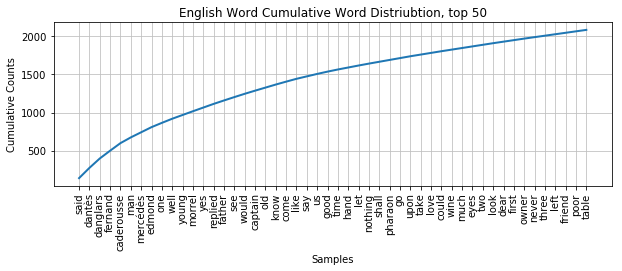

In [719]:
# Cumulative Word Frequency Distribution (English)

# define title
titleName="English Word Cumulative Word Distriubtion, top 50"

# set figure size
plt.figure(figsize=(10,3))

# add title and x-axis label
plt.title(titleName)
plt.xlabel('Top 50 words')

fd_e.plot(50,cumulative = True)

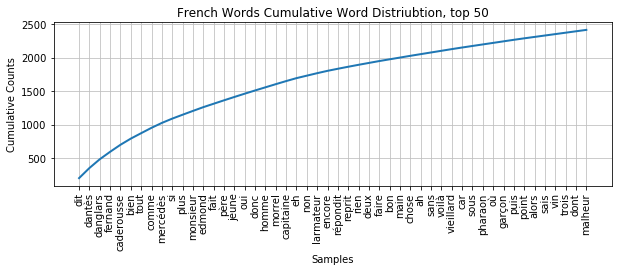

In [720]:
# Cumulative Word Frequency Distribution (French)

# Cumulative Word Frequency Distribution (English)

# define title
titleName="French Words Cumulative Word Distriubtion, top 50"

# set figure size
plt.figure(figsize=(10,3))

# add title and x-axis label
plt.title(titleName)
plt.xlabel('Top 50 words')


fd_f.plot(50,cumulative = True)

#### b. Bigrams and Collocations Building

Let us now build a list of bigrams. Once we have the list of all bigrams we will compare it to the list of most used words already constructed.  

In [721]:
# Create bigram using collocation on filtered English words
bgm = nltk.collocations.BigramAssocMeasures()
finder_e = nltk.collocations.BigramCollocationFinder.from_words(words_e_filtered)

scored_e = finder_e.score_ngrams( bgm.likelihood_ratio  )

# We will construct Group bigrams for the most common word

# Group bigrams by first word in bigram.                                        
prefix_keys_e = collections.defaultdict(list)
for key, scores in scored_e:
    if key[0] in e_mostwords:
        prefix_keys_e[key[0]].append((key[1], scores))

# Sort keyed bigrams by strongest association.                                  
for key in prefix_keys_e:
   prefix_keys_e[key].sort(key = lambda x: -x[1])

# Create bigrams using collartion on filtered French words
finder_f = nltk.collocations.BigramCollocationFinder.from_words(words_f_filtered)

scored_f = finder_f.score_ngrams( bgm.likelihood_ratio  )

# Group bigrams by first word in bigram.                                        
prefix_keys_f = collections.defaultdict(list)
for key, scores in scored_f:
    if key[0] in f_mostwords:
        prefix_keys_f[key[0]].append((key[1], scores))

# Sort keyed bigrams by strongest association.                                  
for key in prefix_keys_f:
   prefix_keys_f[key].sort(key = lambda x: -x[1])

Let us consider the bigrams associated with the word 'edmond' in both language.

In [722]:
# We are going to look at 10 words associcated with word u'edmond', for English words 
print u'edmond', prefix_keys_e[u'edmond'][:10]

edmond [(u'dant\xe8s', 19.240131157869968), (u'continued', 14.647395179824116), (u'merc\xe9d\xe8s', 13.896515931853305), (u'smiling', 12.636510413486159), (u'true', 9.895149247431458), (u'divulged', 9.644579916197653), (u'handsome', 9.644579916197653), (u'observed', 9.644579916197653), (u'providence', 9.644579916197653), (u'release', 9.644579916197653)]


In [723]:
# We are going to look at 10 words associcated with word pere, for French words 
print u'edmond', prefix_keys_f[u'p\xe8re'][:10]

edmond [(u'pamphile', 41.91543945309495), (u'dant\xe8s', 23.281046056772155), (u'fils', 16.488305250525165), (u'm\xe8re', 14.178299197059207), (u'coururent', 10.418355631548241), (u'indiquezmoi', 10.418355631548241), (u'lexc\xe8s', 10.418355631548241), (u'probable', 10.418355631548241), (u'ranimera', 10.418355631548241), (u'rattachant', 10.418355631548241)]


There is not a lot of overlap between the words connected with 'edmond'. We would have expected more overlap between English and equivalent French words. We will now proceed with the graph analysis of these constructs.  

### Graph Analysis

#### 1. Graph Construction

We will now construct a graph from the bigrams.  We will take each words from the most common words and for each of these words, the edges of the graph would be build from the bigrams.  

In [724]:
# Build graph for English words manually (using collection structure create bipartite graph)
g_e = nx.Graph()
for w in e_mostwords:
    for i in range(len(prefix_keys_e[w])):
        g_e.add_edge(w, prefix_keys_e[w][i][0], weight=prefix_keys_e[w][i][1], type='bigram')
        
#g_e=nx.from_dict_of_lists(prefix_keys_e)    

In [725]:
print(nx.info(g_e))
print "Density: " + str(nx.density(g_e))
print "Is connected?: " + str(nx.is_connected(g_e))
print "Is bipartite?: " + str(nx.is_bipartite(g_e))

Name: 
Type: Graph
Number of nodes: 925
Number of edges: 1564
Average degree:   3.3816
Density: 0.00365976365976
Is connected?: True
Is bipartite?: False


In [726]:
# Add language attribute to each node
nx.set_node_attributes(g_e, 'language', 'English')

In [727]:
# Build graph for French words manually (using collection structure create bipartite graph)
g_f = nx.Graph()
for w in f_mostwords:
    for i in range(len(prefix_keys_f[w])):
        g_f.add_edge(w, prefix_keys_f[w][i][0], weight=prefix_keys_f[w][i][1], type='bigram')
        

In [728]:
print(nx.info(g_f))
print "Density: " + str(nx.density(g_f))
print "Is connected?: " + str(nx.is_connected(g_f))
print "Is bipartite?: " + str(nx.is_bipartite(g_f))

Name: 
Type: Graph
Number of nodes: 1076
Number of edges: 1777
Average degree:   3.3030
Density: 0.00307253393274
Is connected?: True
Is bipartite?: False


In [729]:
# Add language attribute to each node
nx.set_node_attributes(g_f, 'language', 'French')

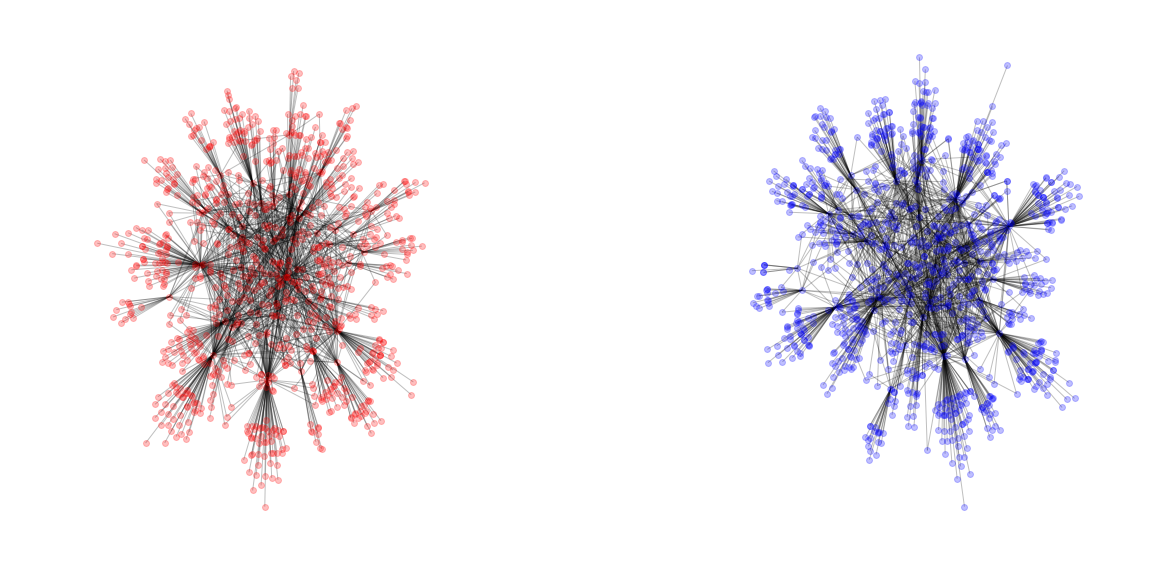

In [730]:
# Set the size of frame for drawing
plt.figure(figsize=(20,10))
plt.axis("off")

g_e_pos = nx.spring_layout(g_e)
g_f_pos = nx.spring_layout(g_f)

for k,v in g_f_pos.items():
    # Shift the x values of every node by 10 to the right
    v[0] = v[0] +2
    
nx.draw_networkx(g_e, pos = g_e_pos, 
                 node_size=35, with_labels=False, node_color='red', alpha=.25)


nx.draw_networkx(g_f, pos = g_f_pos, 
                 node_size=35, with_labels=False, node_color='blue', alpha=.25)

The graph on the left, represents the English version of the text while the graph on the right represents the French version of the text.
From a very high level, the 2 graphs demonstrate similar patterns.  We will proceed to study the 2 graphs and attempt to link them by mapping words with same meaning in the 2 languages.

#### 2. Graphs Analysis

We will first consider various measures of centrality for our 2 graphs.

In [731]:
# Function to return sorted degree list
def sorted_map( map):
    ms = sorted( map.iteritems(),
                key = lambda (k, v): (-v, k))
    return ms

##### a. Degree of Centrality

In [732]:
# Determine the degrees 
deg_e = nx.degree(g_e)
deg_f = nx.degree(g_f)

ds_e = sorted_map(deg_e)
ds_f = sorted_map(deg_f)

In [733]:
#Top 10 nodes with highest degree (English)
ds_e[:10]

[(u'dant\xe8s', 129),
 (u'danglars', 111),
 (u'fernand', 102),
 (u'caderousse', 89),
 (u'man', 74),
 (u'merc\xe9d\xe8s', 69),
 (u'one', 63),
 (u'edmond', 61),
 (u'said', 58),
 (u'well', 51)]

In [734]:
#Top 10 nodes with highest degree (French)
ds_f[:10]

[(u'dant\xe8s', 144),
 (u'danglars', 114),
 (u'fernand', 109),
 (u'caderousse', 99),
 (u'bien', 87),
 (u'comme', 76),
 (u'merc\xe9d\xe8s', 76),
 (u'dit', 74),
 (u'tout', 69),
 (u'si', 63)]

The words with the highest degrees correspond to the most common words in each text. This is not surprising based on how we build the graphs. 

In [735]:
# Degree of Centrality
dc_e = nx.degree_centrality(g_e)
dc_f = nx.degree_centrality(g_f)

dcs_e = sorted_map(dc_e)
dcs_f = sorted_map(dc_f)

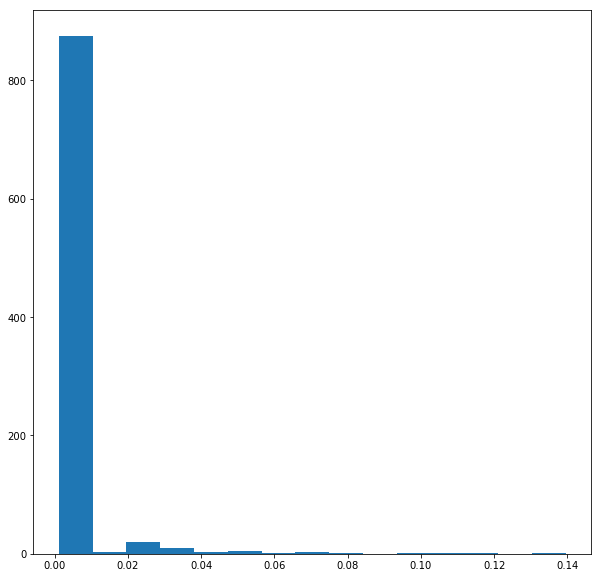

In [736]:
plt.figure(figsize=(10,10))
# Plot Histogram of degrees
h=plt.hist(dc_e.values(), 15)

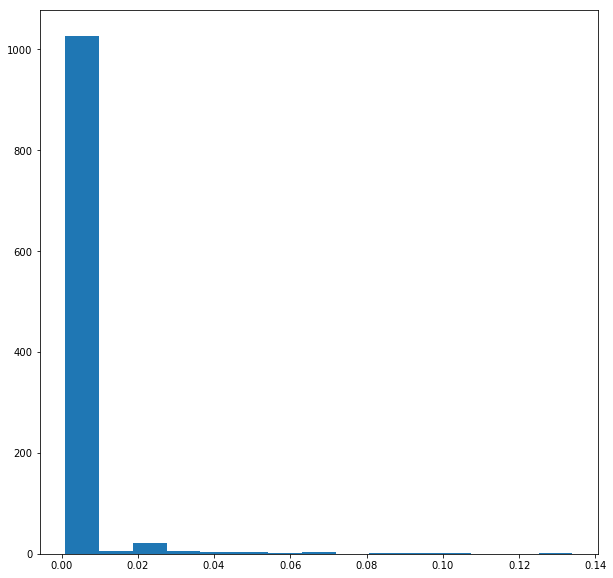

In [737]:
plt.figure(figsize=(10,10))
# Plot Histogram of degrees
h=plt.hist(dc_f.values(), 15)

In [738]:
#Top 10 English words with highest measure of degree
dcs_e[:10]

[(u'dant\xe8s', 0.1396103896103896),
 (u'danglars', 0.12012987012987013),
 (u'fernand', 0.11038961038961038),
 (u'caderousse', 0.09632034632034632),
 (u'man', 0.08008658008658008),
 (u'merc\xe9d\xe8s', 0.07467532467532467),
 (u'one', 0.06818181818181818),
 (u'edmond', 0.06601731601731602),
 (u'said', 0.06277056277056277),
 (u'well', 0.05519480519480519)]

In [739]:
# Top 10 French words with highest measure of degree
dcs_f[:10]

[(u'dant\xe8s', 0.13395348837209303),
 (u'danglars', 0.10604651162790699),
 (u'fernand', 0.10139534883720931),
 (u'caderousse', 0.09209302325581396),
 (u'bien', 0.08093023255813954),
 (u'comme', 0.07069767441860465),
 (u'merc\xe9d\xe8s', 0.07069767441860465),
 (u'dit', 0.06883720930232559),
 (u'tout', 0.06418604651162792),
 (u'si', 0.0586046511627907)]

The character names have the highest degree.  They are the most used in their respective text. We will look now at the closeness measure.

##### b. Closeness Centrality

In [740]:
# Closeness Centrality

cl_e = nx.closeness_centrality(g_e)
cl_f = nx.closeness_centrality(g_f)

cls_e = sorted_map(cl_e)
cls_f = sorted_map(cl_f)

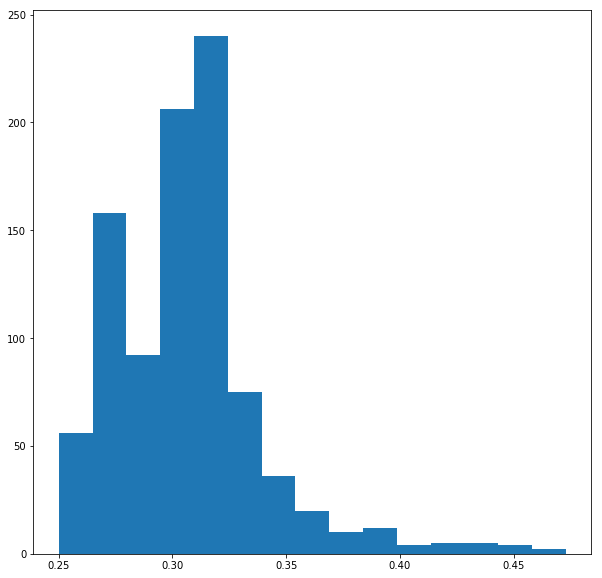

In [741]:
plt.figure(figsize=(10,10))
# Histogram for Closeness Centrality
h=plt.hist(cl_e.values(), 15)

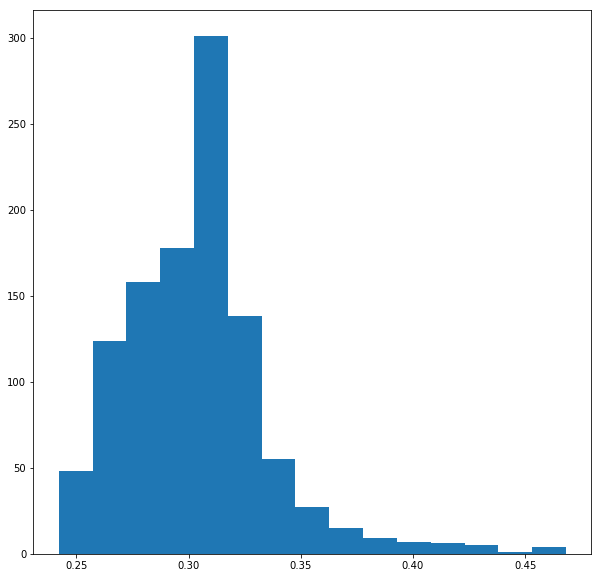

In [742]:
plt.figure(figsize=(10,10))
# Histogram for Closeness Centrality
h=plt.hist(cl_f.values(), 15)

Let us display the top 10 words based on closeness in both language.  

In [743]:
cls_e[:10]

[(u'dant\xe8s', 0.4728761514841351),
 (u'said', 0.47166921898928027),
 (u'danglars', 0.456973293768546),
 (u'fernand', 0.4522760646108664),
 (u'caderousse', 0.45095168374816985),
 (u'edmond', 0.44573082489146165),
 (u'one', 0.43400657585721),
 (u'know', 0.43380281690140843),
 (u'see', 0.43380281690140843),
 (u'well', 0.43278688524590164)]

In [744]:
cls_f[:10]

[(u'dant\xe8s', 0.468205574912892),
 (u'fernand', 0.4584221748400853),
 (u'dit', 0.4572522330923012),
 (u'bien', 0.4543533389687236),
 (u'danglars', 0.4387755102040816),
 (u'caderousse', 0.4378818737270876),
 (u'oui', 0.4378818737270876),
 (u'comme', 0.4377035830618892),
 (u'si', 0.4306891025641026),
 (u'tout', 0.4252373417721519)]

The character name are again at the top.  We also notice that the same word 'said/dit' close to the top in both language for closness as it was for degree.  

We will now condider the betweeness measure.  

##### c. Betweenness measure

In [745]:
bw_e = nx.betweenness_centrality(g_e)
bw_f = nx.betweenness_centrality(g_f)

bws_e = sorted_map(bw_e)
bws_f = sorted_map(bw_f)

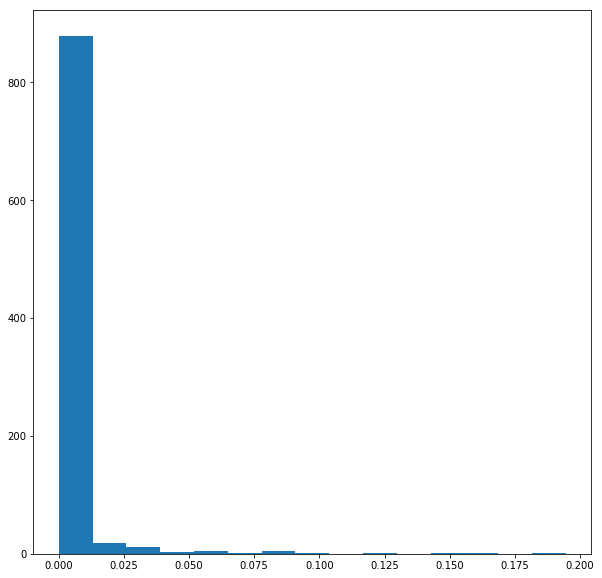

In [746]:
plt.figure(figsize=(10,10))
# Histogram for Betweeness Centrality
h=plt.hist(bw_e.values(), 15)

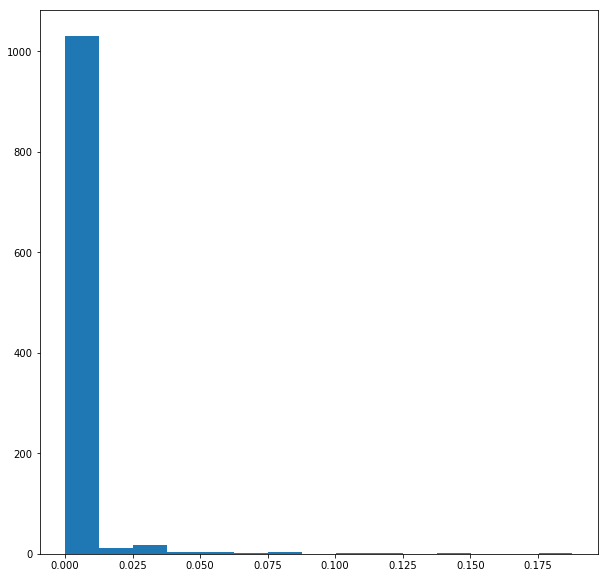

In [747]:
plt.figure(figsize=(10,10))
# Histogram for Betweeness Centrality
h=plt.hist(bw_f.values(), 15)

In [748]:
bws_e[:10]

[(u'dant\xe8s', 0.19455582349588194),
 (u'danglars', 0.1615696758203286),
 (u'fernand', 0.14616165217726543),
 (u'caderousse', 0.12061314623177355),
 (u'man', 0.0986541924348285),
 (u'one', 0.08740877470582048),
 (u'said', 0.08371619095409327),
 (u'edmond', 0.08210990328779139),
 (u'merc\xe9d\xe8s', 0.08191233040485954),
 (u'like', 0.0671367846199819)]

In [749]:
bws_f[:10]

[(u'dant\xe8s', 0.18775178055752184),
 (u'danglars', 0.14874501135121826),
 (u'fernand', 0.14519790073238953),
 (u'caderousse', 0.12334404800460809),
 (u'comme', 0.11611350235606116),
 (u'bien', 0.10946134566984507),
 (u'merc\xe9d\xe8s', 0.08734544167237003),
 (u'dit', 0.08164150102929126),
 (u'tout', 0.07805790687833518),
 (u'si', 0.07243671193429031)]

Again, we have the characters with the highest "betweeness" level and again the word "said/dit" is at the top. Since there is quite a bit of dialogue in the first few chapter of the book, it would be expected to have this word to be prevalent in both language.

##### d. Eigenvector Centrality

In [750]:
# Eigenvector Centrality
egv_e = nx.eigenvector_centrality_numpy(g_e)
egv_f = nx.eigenvector_centrality_numpy(g_f)

egvs_e = sorted_map(egv_e)
egvs_f = sorted_map(egv_f)

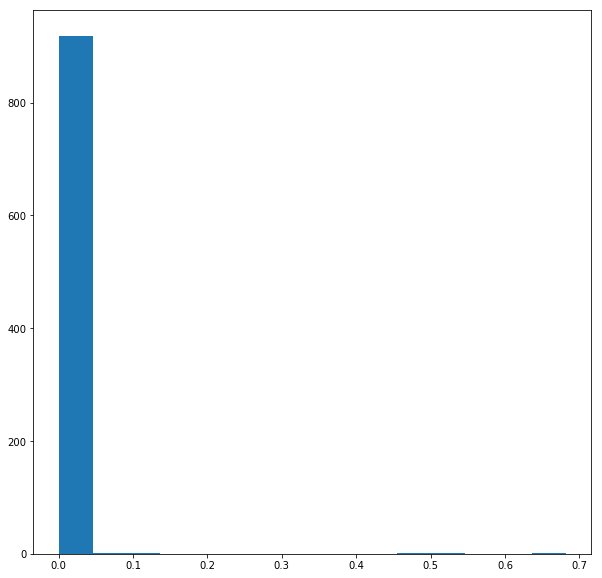

In [751]:
plt.figure(figsize=(10,10))
# Histogram for Eigenvector Centrality
h=plt.hist(egv_e.values(), 15)

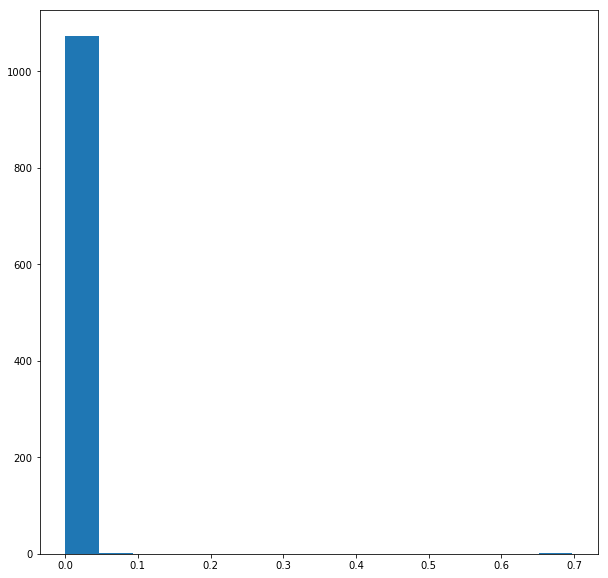

In [752]:
plt.figure(figsize=(10,10))
# Histogram for Eigenvector Centrality
h=plt.hist(egv_f.values(), 15)

In [753]:
egvs_e[0:10]

[(u'man', 0.6818684708080879),
 (u'young', 0.5127884818961412),
 (u'old', 0.46476720830876367),
 (u'said', 0.11764880362331898),
 (u'girl', 0.10241297092227311),
 (u'sailor', 0.05472550658586015),
 (u'twentyfive', 0.048013850628674054),
 (u'replied', 0.04390503726637319),
 (u'dant\xe8s', 0.03719771523919892),
 (u'yes', 0.03005970351506668)]

In [754]:
egvs_f[0:10]

[(u'bien', 0.6975098658678178),
 (u'eh', 0.6884909231503906),
 (u'sais', 0.08981131296732622),
 (u'dit', 0.03849589315430995),
 (u'press\xe9', 0.03662420353991338),
 (u'certainement', 0.03654139579512816),
 (u'fait', 0.031620540316272795),
 (u'connue', 0.025993344722290177),
 (u'sachiez', 0.025993344722290177),
 (u'amicale', 0.025993344722290174)]

It is interesting to note that the words in either language with highest eigenvector are not the same as the ones with other high centrality measures. We will surmise that these words may act as link between various clusters of words.  We will perform that Island Analysis to see whether we can identify some interesting clusters.

##### c. Island Analysis

In [755]:
# Trim edges function is taken directly from SNABook

def trim_edges(g, weight=1):
    """
    Remove edges with weights less then a threshold parameter ("weight")
    """
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
     
    return g2
            

def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [756]:
# Island Analysis English Words
cc_e = list(nx.connected_component_subgraphs(g_e))[0]
islands_e = island_method(cc_e)

print ('Weight  Words  Groups')
for i in islands_e:
    print(' %d          %2d       %d' 
          %(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1])))))
    

Weight  Words  Groups
 0          925       1
 37          16       7
 74           9       4
 111           5       2
 148           3       1
 185           2       1


In [757]:
# Island Analysis - French words
cc_f = list(nx.connected_component_subgraphs(g_f))[0]
islands_f = island_method(cc_f)

print ('Weight  Words  Groups')
for i in islands_f:
    print(' %d          %2d       %d' 
          %(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1])))))

Weight  Words  Groups
 0          1076       1
 46          13       6
 92           8       4
 138           4       2
 184           2       1
 230           2       1


We will consider the water level which provdides the most groups (level = 37 for English) and (level = 46 for French).  
From the breakdown of the group, it appears that we are facing the same problem as we had when we did not consider the "proper names" in our original words analysis.

In [758]:
g_e37 = trim_edges(g_e, 37)
g_f46 = trim_edges(g_f, 46)

In [759]:
nx.nodes(g_e37)

[u'replied',
 u'danglars',
 u'said',
 u'old',
 u'months',
 u'mind',
 u'young',
 u'us',
 u'three',
 u'leclere',
 u'let',
 u'never',
 u'girl',
 u'captain',
 u'come',
 u'man']

In [760]:
nx.nodes(g_f46)

[u'doute',
 u'lecl\xe8re',
 u'marin',
 u'mois',
 u'sans',
 u'jeune',
 u'morrel',
 u'eh',
 u'fille',
 u'bien',
 u'trois',
 u'monsieur',
 u'capitaine']

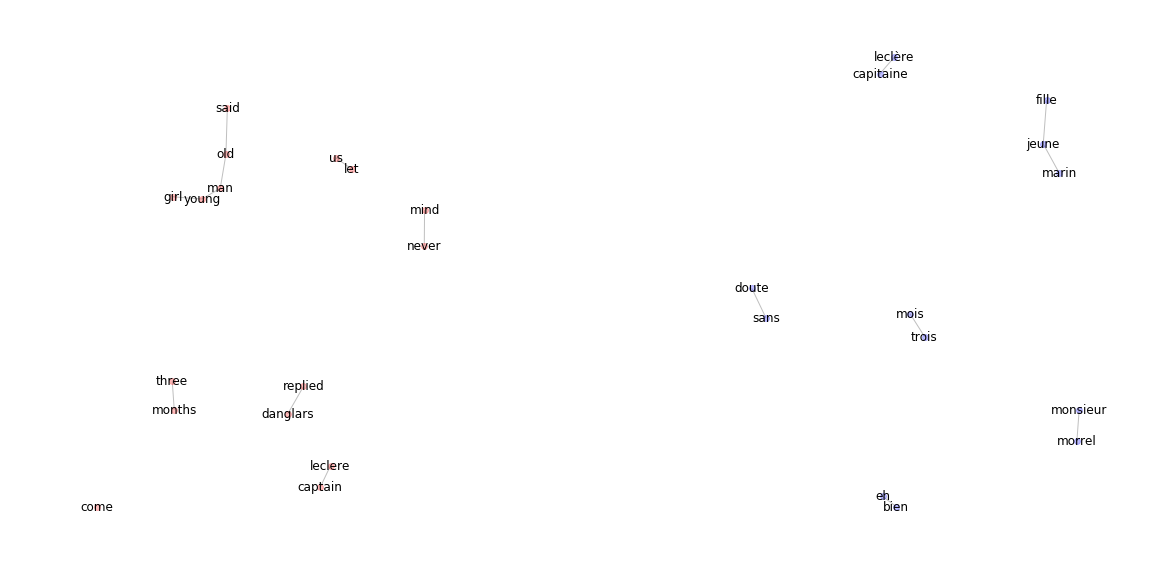

In [761]:
# Set the size of frame for drawing
plt.figure(figsize=(20,10))
plt.axis("off")

g_e_pos = nx.spring_layout(g_e37)
g_f_pos = nx.spring_layout(g_f46)

for k,v in g_f_pos.items():
    # Shift the x values of every node by 10 to the right
    v[0] = v[0] +2
    
nx.draw_networkx(g_e36, pos = g_e_pos, 
                 node_size=35, with_labels=True, node_color='red', alpha=.25)


nx.draw_networkx(g_f45, pos = g_f_pos, 
                 node_size=35, with_labels=True, node_color='blue', alpha=.25)

It is difficult to make any conclusion, although it is interesting to see that "Monsieur Morrel" does not occurred in the English graph but it does in the French one. Similarly, "Danglars replied" appears in the English side but not in French one. Words with high eigenvectors centrality measures such as "man", "old", "yound" "said" "girl" for English and "eh", "bien" for French constitute little clusters. 

We will further our analysis and consider the neighborhood of the each of the most prominent characters for both French and English.

##### d. Ego Networks Analysis for main characters

To simply the graph and the analysis, we will start by picking the one with the least number of nodes connected to it; edmond

In [762]:
# Let us construct neighborhood for the most preminent characters:
n1=u'edmond'

sg_edmond_e = nx.ego_graph(g_e, n=n1, radius = 1, center=True)
sg_edmond_f = nx.ego_graph(g_f, n=n1, radius = 1, center=True)

In [763]:
print(nx.info(sg_edmond_e))

Name: 
Type: Graph
Number of nodes: 62
Number of edges: 197
Average degree:   6.3548


In [764]:
print(nx.info(sg_edmond_f))

Name: 
Type: Graph
Number of nodes: 57
Number of edges: 142
Average degree:   4.9825


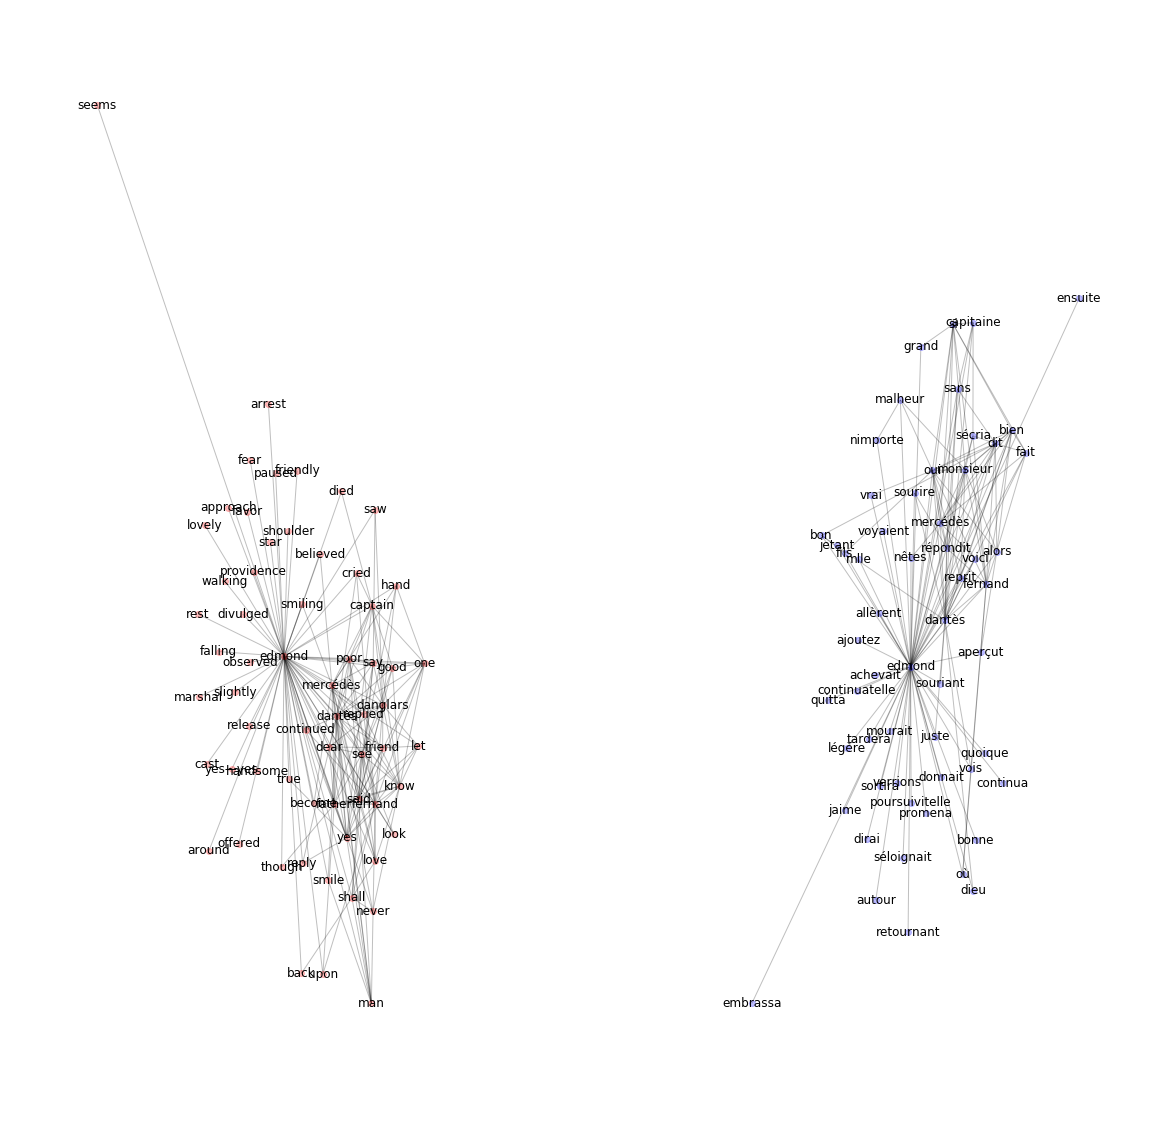

In [765]:
# Set the size of frame for drawing
plt.figure(figsize=(20,20))
plt.axis("off")
g_e_pos = nx.spring_layout(sg_edmond_e)
nx.draw_networkx(sg_edmond_e, pos = g_e_pos, 
                 node_size=35, with_labels=True, node_color='red', alpha=.25)

g_f_pos = nx.spring_layout(sg_edmond_f)

for k,v in g_f_pos.items():
    # Shift the x values of every node to the right
    v[0] = v[0] +2
    
nx.draw_networkx(sg_edmond_f, pos = g_f_pos, 
                 node_size=35, with_labels=True, node_color='blue', alpha=.25)

In [766]:
# Set Node and Edges attributes 

nx.set_edge_attributes(sg_edmond_e, 'type', 'bigram')
nx.set_node_attributes(sg_edmond_e, 'language', 'English')

nx.set_edge_attributes(sg_edmond_f, 'type', 'bigram')
nx.set_node_attributes(sg_edmond_f, 'language', 'French')


In [767]:
# Generate a list of nodes 
l_edmond_e = nx.nodes(sg_edmond_e)
l_edmond_f = nx.nodes(sg_edmond_f)
#import csv
#with open('edmond_mapping.csv', 'w') as f:
#    writer = csv.writer(f)
#    for val in l_edmond_e:
#        writer.writerow([val.encode('utf8')])

In [768]:
# Composition of the 2 graphs and mapping of the translation

sg_edmond = nx.compose(sg_edmond_e, sg_edmond_f, name=None)

# Build Edge with type = 'translate'
sg_edmond_translate = [(u'captain', u'capitaine'), (u'cast', u'jetant'), (u'continued', u'continua'), (u'continued', u'continuatelle'), \
                       (u'cried', u's\xe9cria'), (u'dear', u'bon'), (u'dear', u'bonne'), (u'love', u'jaime'), \
                       (u'replied', u'r\xe9pondit'), (u'said', u'dit'), (u'saw', u'verrions'), (u'say', u'dirai'), (u'see', u'vois'), \
                       (u'smile', u'sourire'), (u'smiling', u'souriant'), (u'walking', u'promena'), (u'yes', u'oui'), (u'true', u'vrai')]

sg_edmond.add_edges_from(sg_edmond_translate, weight = 0, type='translate')


{u'father': <matplotlib.text.Text at 0x22580ac8>,
 u'fils': <matplotlib.text.Text at 0x22580710>}

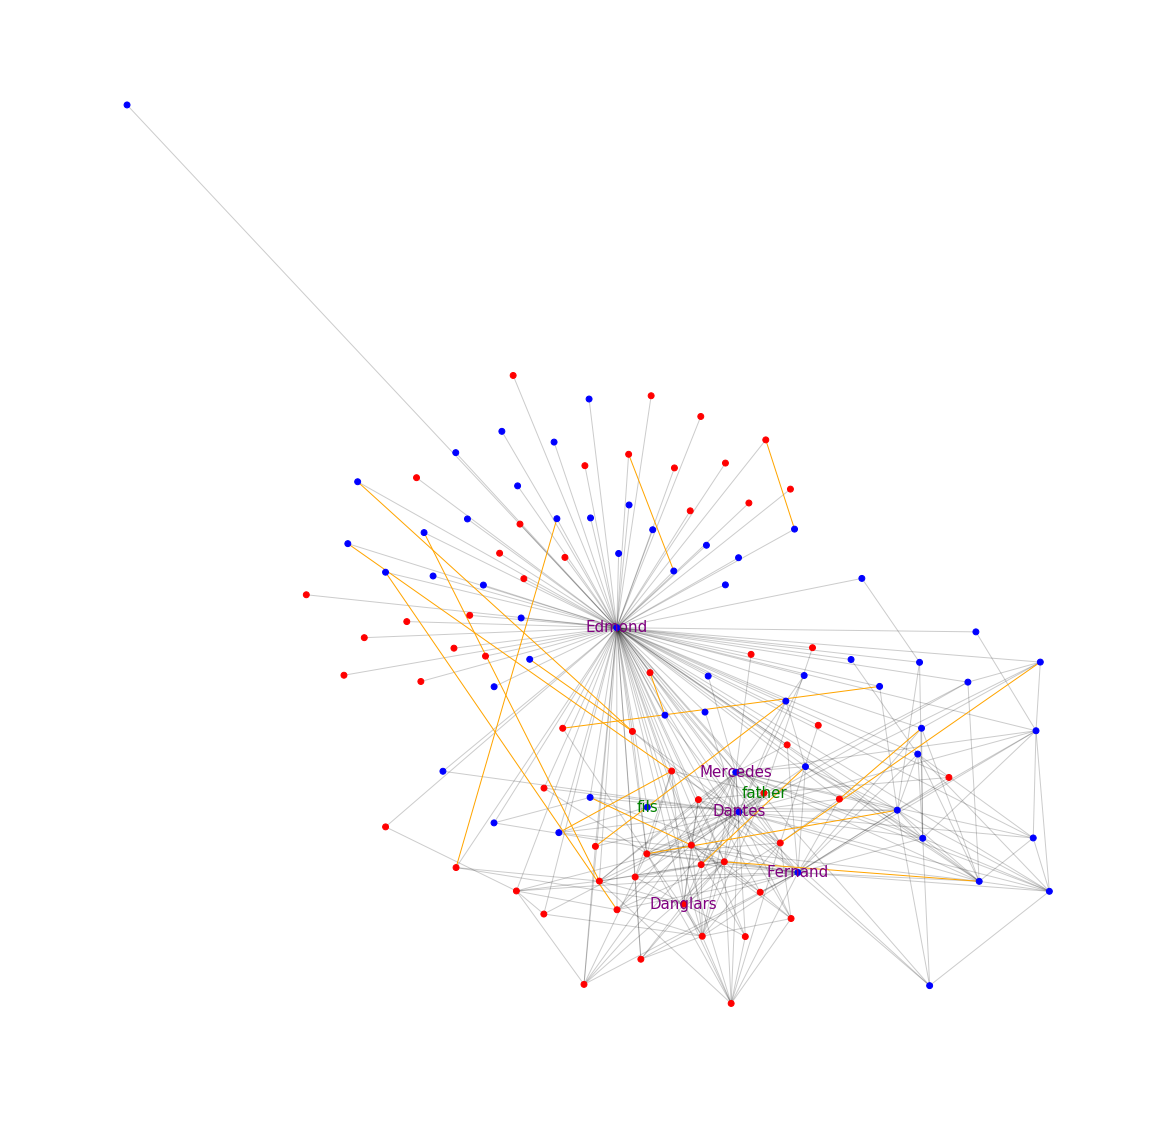

In [769]:
# create empty list for node colors
node_color = []

# for each node in the graph
for node in sg_edmond.nodes(data=True):

    # if the node has the attribute 'English'
    if 'English' in node[1]['language']:
        node_color.append('red')

    # if the node has the attribute group1
    else:
        node_color.append('blue')

bigrams_edges = [(u,v) for u,v,e in sg_edmond.edges(data=True) if e['type'] == 'bigram']
translate_edges = [(u,v) for u,v,e in sg_edmond.edges(data=True) if e['type'] == 'translate']        
        
# Set the size of frame for drawing
plt.figure(figsize=(20,20))
plt.axis("off")

label_seed_characters = {u'edmond': 'Edmond', u'danglars': 'Danglars', u'fernand': 'Fernand', u'dant\xe8s': 'Dantes', \
                         u'merc\xe9d\xe8s': 'Mercedes'}
label_seed_other = {u'father': 'father', u'fils': 'fils'}

# Nodes Layout      
pos_edmond = nx.spring_layout(sg_edmond)

# nodes
nx.draw_networkx_nodes(sg_edmond,pos_edmond,node_size=35, with_labels=False, node_color=node_color , alpha=1)

# edges
nx.draw_networkx_edges(sg_edmond,pos_edmond,edgelist=bigrams_edges, width=1, alpha=0.2, edge_color = 'black')
nx.draw_networkx_edges(sg_edmond,pos_edmond,edgelist=translate_edges, width=1, alpha=1, edge_color = 'orange')
nx.draw_networkx_labels(sg_edmond, pos_edmond, label_seed_characters, font_size = 15, font_color = 'purple')
nx.draw_networkx_labels(sg_edmond, pos_edmond, label_seed_other, font_size = 15, font_color = 'green')

This is a graph with both English words (red) and French words (blue) on the same graph.  The orange edges represents the translated words. Meaning that the 2 nodes linked by a "translation" edge indicates that the word as the same meaning in English and in French.  The character names that are linked to Edmond (our seed node) are in purple. From the graph, it is clear that we do not have a lot of words that appear in both English and French words linked to Edmond. In addition, the word "father" appears in the set of English words, however the word "fils" (son) appears in the French words. We found this quite interesting. In the first 5 chapters of the book, we are introduced to the relationship between Edmond Dantes (the main protagonist) and his fater.  It would appear that relationship is described in the English text as Edmond has a father and in the French text has Edmond is a son.  This may consistent in the difference between the 2 languages as "passive" construction are more favored in French than they area in English.  

### Conclusions

We set-out to determine whether the equivalent words are consitently present in bigrams for French and English languages for same text. We cannot really conclude that they are or that we have a consistent differences.  The problem might have resided in our original approach.  In retrospect, it might have been more judicious to form the bigrams first and then filter stopwords and possibly other functional words.  

Also it is difficult to determine whether we should filter most functional words (other than stop words) and retain some context of the story. Only preserving content words (words with meaning and information) might have made the mapping word to equivalent word between the 2 languages easier. 

Finally, mapping word to equivalent words between 2 languages are difficult unless the words have very specific meaning when the word is not part of a sentence.

Further analysis with possibly more text to start and possibly better filters may lead to more precise conclusion.


### Lessons Learned

* Natural Language Processing is very interesting but is a time consuming endeavor. Successive iterations of the analysis of the results to required to determine whether some operations needs refining specially around the filtering punctuation and stopwords.

* NLTK is not as robust in handling French Language as it is in handling English language.

* Graph Analysis as tool is very powerful but still somewhat difficut when using it to analyse a scenario other than social network.

I learned a tremendous amount in this class.

Thank you

### Resources and References

#### Handling 'uft-8' encoding
When first loaded the text (encoded with 'utf-8) I got an error on word-tokenizer.
https://stackoverflow.com/questions/18649512/unicodedecodeerror-ascii-codec-cant-decode-byte-0xe2-in-position-13-ordinal
I tried several solution to tokenize with uft-8 code but could not get it to work, such as:
* import codecs
* open with read().decode('utf-8)
...
Changing the default encoding in sys found on stackoverflow above seemed to work. Since this is not recommended approach, finally manage to do it another way.

https://www.azavea.com/blog/2014/03/24/solving-unicode-problems-in-python-2-7/
This article (above) I found very useful in understanding how to deal with unicode problem.
***
#### Remove punctuation as tokenize
https://stackoverflow.com/questions/15547409/how-to-get-rid-of-punctuation-using-nltk-tokenizer/15555162

***

#### Collocation  
http://www.nltk.org/howto/collocations.html

https://stackoverflow.com/questions/8683588/understanding-nltk-collocation-scoring-for-bigrams-and-trigrams

#### Collection
https://docs.python.org/2/library/collections.html#collections.defaultdict

***

#### Eigenvector not converging
https://stackoverflow.com/questions/43208737/using-networkx-to-calculate-eigenvector-centrality

***  

Social Network Analysis for Start Up by Maksim Tsvetovat and Alexander Kouznetsov

Natural Language Processing with Python by Steven Bird, Ewan Klein and Edward Loper 
